# Attention
In this notebook, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.

We will implement attention scoring as well as calculating an attention context vector.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## But first, what is Attention?

*In psychology, __attention__ is the cognitive process of selectively concentrating on one or a few things while ignoring others.*

A neural network is considered to be an effort to mimic human brain actions in a simplified manner. Attention Mechanism is also an attempt to implement the same action of selectively concentrating on a few relevant things, while ignoring others in deep neural networks. 

For instance, let’s say we are seeing a group photo of our first school. Typically, there will be a group of children sitting across several rows, and the teacher will sit somewhere in between. Now, if anyone asks the question, *“How many people are there?”*, how will we answer it? Simply by counting heads, right? We don’t need to consider any other things in the photo. 

Now, if anyone asks a different question, *“Who is the teacher in the photo?”*, our brain knows exactly what to do. It will simply start looking for the features of an adult in the photo. The rest of the features will simply be ignored. This is the __‘Attention’__ which our brain is very adept at implementing.

### How Attention Mechanism was Introduced in Deep Learning?###
The __Attention__ mechanism is one of the most valuable breakthroughs in Deep Learning research in the last decade. It has spawned the rise of so many recent breakthroughs in natural language processing (NLP), including the Transformer architecture and Google’s BERT. It emerged as an improvement over the encoder decoder-based neural machine translation system in natural language processing (NLP). Later, this mechanism, or its variants, was used in other applications, including computer vision, speech processing, etc. 

Before [Bahdanau et al](https://arxiv.org/abs/1409.0473) proposed the first Attention model in 2015, neural machine translation was based on encoder-decoder RNNs/LSTMs. Both encoder and decoder are stacks of LSTM/RNN units. It works in the two following steps:

- The encoder LSTM is used to process the entire input sentence and encode it into a context vector, which is the last hidden state of the LSTM/RNN. This is expected to be a good summary of the input sentence. All the intermediate states of the encoder are ignored, and the final state id supposed to be the initial hidden state of the decoder
- The decoder LSTM or RNN units produce the words in a sentence one after another

![An encoder-decoder neural network architecture for Machine Translation w/o Attention](https://miro.medium.com/max/1013/1*1ui7iDq956eDs-mAZHEdIg.png)
The main drawback of this approach is evident. If the encoder makes a bad summary, the translation will also be bad. And indeed it has been observed that the encoder creates a bad summary when it tries to understand longer sentences. It is called the long-range dependency problem of RNN/LSTMs. 

__So is there any way we can keep all the relevant information in the input sentences intact while creating the context vector?__

[Bahdanau et al (2015)](https://arxiv.org/abs/1409.0473) came up with a way we can keep all the relevant information in the input sentences intact while creating the context vector. He suggested that not only can all the input words be taken into account in the context vector, but relative importance should also be given to each one of them. So, whenever the proposed model generates a word, it inspects for a set of positions in the source sentence where the most relevant information is available. This idea is called __Attention__.

![attention mechanism proposed by Bahdanau et al.](https://miro.medium.com/max/799/1*9Lcq9ni9aujScFYyyHRhhA.png) 

There is also another major type of Attention called Luong Attention published by [Luong et al](https://arxiv.org/pdf/1508.04025.pdf). While the underlying principles of Attention are the same in these 2 types, their differences lie mainly in their architectures and computations. 

The Loung Attention is different from Bahnadau Attention in the following aspects:

- In __Luong__ attention, they consider the decoder hidden state at time `t`. Then calculate attention scores and from that get the context vector which will be concatenated with hidden state of the decoder and then predict.

    But in the __Bahdanau__, at time `t`, they consider the `t-1` hidden state of the decoder to calculate the alignment scores, context vectors as above. And then concatenate this context with hidden state of the decoder at `t-1`. This again goes through a deep-output and a maxout layer before making predictions. 
    
    
- __Luong__ has diffferent types of alignment score model. __Bahdanau__ has only additive/concat score alignment model. 

Ref: [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf) 

![Score Function](https://miro.medium.com/max/1634/1*oosK1XGaYr0AoSxfs9fx5A.png)![Score function Citations](https://miro.medium.com/max/843/1*XzPD6cyrbWPP0r27PXVWOw.png)

Technically, the key concept of **Attention** is to calculate an __attention weight vector__ or the __context vector__, which is then used to amplify the signal from of most relevant parts of the input sequence, and in the same time drown out the irrelevant parts.

It involves the following steps:

    1) calculate the attention scores for the hidden states
    2) apply softmax on the attention scores
    3) weigh the hidden states according to the softmax scores
    4) concatenate the weighted vectors to obtain the `context vector`

<img src='images/context vector.jpg'>

Now, let's understand how the *Attention scores* are generated.


## Attention Scoring
The __Attention Scores__ are calculated based on a scoring function. 

_Note: Although there are many scoring functions, we will focus on the scoring functions from [Luong et al](https://arxiv.org/pdf/1508.04025.pdf) only. More specifically, only the **Dot Scoring** function._

### Inputs to the scoring function

Let's start by looking at the inputs that we pass to the scoring function. 
The attention scoring function takes two inputs:
- the hidden state of the decoder 
- the set of hiddens states of the encoder

__a) the hidden state of the decoder__

Let's assume we're in the first step in the decoding phase, and the decoder hidden state has an embedding space of 3 (assuming a toy RNN with three hidden nodes -- not usable in real life, but easier to illustrate).

In [30]:
dec_hidden_state = [5,1,20]

Let's visualize this hidden state vector:

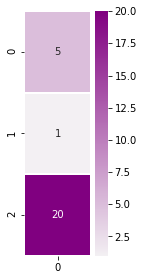

In [31]:
# Let's visualize our decoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)
plt.show()

**b) the set of hiddens states of the encoder**

Let's now look at the set of hiddens states of the encoder:

In [45]:
annotations = np.transpose([[3,10,25], [39,2,5], [1,33,5], [4,3,25.3]])

And it can be visualized like this (each column is a hidden state of an encoder time step):

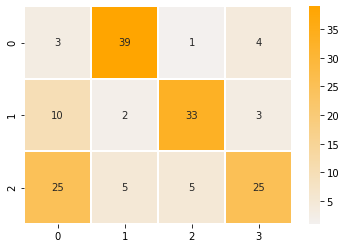

In [46]:
# Let's visualize our annotation (each column is an annotation)
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### Implement Scoring Function
Let's calculate the scores of all the annotations (hidden states). 

The [Luong et al](https://arxiv.org/pdf/1508.04025.pdf) paper put forwards 3 scoring functions:

<img src="images/scoring_functions.png" />

In this project, we will try to implement only the "DOT" scoring method. This scoring function is quite straightforward and just involves a simple one-step matrix multiplication. 

To do that, we'll have to transpose `dec_hidden_state` and [matrix multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html) it with `annotations`.

In [47]:
def dot_attention_score(dec_hidden_state, annotations):
    
    # return the product of dec_hidden_state transpose and enc_hidden_states
    return np.matmul(np.transpose(dec_hidden_state), annotations)
    
attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

array([525., 297., 138., 529.])

The above scores will decide which of the four vectors (hidden encoder states) will get the most attention from the decoder (for the current time step).

## Softmax
Now that we have our scores, let's apply softmax:
<img src="images/softmax.png" />

In [48]:
def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) 

attention_weights = softmax(attention_weights_raw)
attention_weights

array([1.79862100e-002, 1.72106703e-101, 1.52396559e-170, 9.82013790e-001])

Even when knowing which annotation will get the most focus, it's interesting to see how drastic softmax makes the end score become. The first and last annotation had the respective scores of 525 and 529. But after softmax, the attention they'll get is 0.017 and 0.982 respectively.

## Applying the scores back on the annotations
Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells)

<img src="images/Context_vector.png" />

In [49]:
def apply_attention_scores(attention_weights, annotations):
    # Multiply the annotations by their weights
    return attention_weights * annotations

applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[5.39586299e-002, 6.71216142e-100, 1.52396559e-170,
        3.92805516e+000],
       [1.79862100e-001, 3.44213406e-101, 5.02908646e-169,
        2.94604137e+000],
       [4.49655249e-001, 8.60533515e-101, 7.61982797e-170,
        2.48449489e+001]])

Let's visualize how the context vector looks now that we've applied the attention scores back on it:

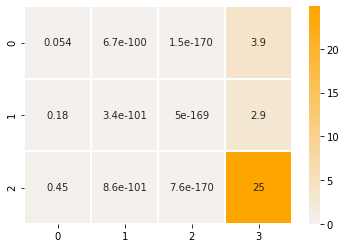

In [50]:
# Let's visualize our annotations after applying attention to them
ax = sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the first, second and third annotations (columns) have been nearly wiped out. The fourth annotation is the most pronounced.

## Calculating the Attention Context Vector
All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector.


In [51]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.98201379,  3.12590347, 25.29460414])

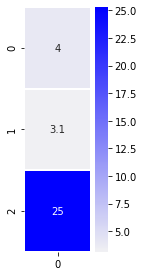

In [53]:
# Let's visualize the attention context vector
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1)
plt.show()

The context vector is then concatenated with the current decoder hidden state and passed it through a Feed Forward Network to produce the result of this decoding time step. 

We will repeat the above steps to generate the output at every time-step untill some terminating condition is fulfilled.

The complete steps can be summarized using the below picture:

<img src='images/final.jpg'>

## Create Attention layer

Now that we have understood how __Attention__ works, we will combine the above steps to create a layer `AttentionLayer()` so we can plug it into our model like any other layer.

In [90]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

In [85]:
class Attention(Layer):
    
    """Class for Attention Layer"""
    
    def __init__(self, **kwargs):
        """
        Constructor Method
        """
        super(Attention, self).__init__(**kwargs)

    def call(self, query, key):
        """
        This method defines the main logic of Attention.
        
        Inputs:
            query: current time-step decoder hidden state  
                -> (batch_size, hidden_dim) 
            key: all encoder all hidden state           
                -> (batch_size, seq_len, hidden_dim) 
        
        Returns:
            Returns the context vector
                -> (batch_size, 1, hidden_dim)
                
        Note: The DOT scoring methods requires that the embedding dimension of
        both encoder and decoder are same for it to work.
        """

        # step 0: fixing the dimension of query
        query = tf.expand_dims(query, 1)                 # (batch_size, 1, hidden_dim)

        # step 1. calculate alignment score 
        scores = tf.matmul(query, key, transpose_b=True) # (batch_size, 1, seq_len)
        
        # step 2. apply softmax to the alignment scores  # (batch_size, 1, seq_len)
        a = tf.nn.softmax(scores)
        
        # step 3. multiply the softmaxed scores to "key" to get the "context vector"
        c_vector = tf.matmul(a, tf.cast(key, dtype=tf.float32)) 
        # (b, 1, seq_len) * (b, seq_len, hidden_dim)    -> (batch_size, 1, hidden_dim)

        return c_vector
    
    def get_config(self):
        """
        This method collects the input shape and other information about the model.
        """
        return super(Attention,self).get_config()

### Test the layer:

In [87]:
batch_size = 2
hidden_dim = 10
seq_len = 5

dec_hidden_state  = tf.constant(np.random.rand(batch_size, hidden_dim), dtype=tf.float32)
enc_hidden_states = tf.constant(np.random.rand(batch_size, seq_len, hidden_dim), dtype=tf.float32)                       

In [88]:
attn_layer = Attention()
cv = attn_layer(dec_hidden_state, enc_hidden_states)

In [89]:
cv.shape

TensorShape([2, 1, 10])

The `AttentionLayer()` returns context vector of shape `[1, hidden_dim]` for all the rows, as expected.